In [1]:
import pandas as pd
import numpy as np
from typing import List, Tuple, Dict, Any

seed = 18022004
np.random.seed(seed)

In [39]:
data_prefix: str = 'data'
repo_prefix: str = f'{data_prefix}/repos'

# data_name_template: str = '500_{}_sample_dataset.parquet'
# data_types = ['log', 'test', 'others']

# sampled_data_name: Dict[str, str] = {data_type: data_name_template.format(data_type) for data_type in data_types}

# log_df: pd.DataFrame = pd.read_parquet(f'{data_prefix}/{sampled_data_name["log"]}', engine = 'pyarrow')
# test_df: pd.DataFrame = pd.read_parquet(f'{data_prefix}/{sampled_data_name["test"]}', engine = 'pyarrow')
# others_df: pd.DataFrame = pd.read_parquet(f'{data_prefix}/{sampled_data_name["others"]}', engine = 'pyarrow')

data_name = 'full_others_code_dataset.parquet'
# data_name = 'data_method_level.parquet'
# data_name = 'data_method_30k_test.parquet'
data_name = 'results_data_method_30k_test.parquet'

data_df: pd.DataFrame = pd.read_parquet(f'{data_prefix}/{data_name}', engine = 'pyarrow')

In [12]:
# reset index

data_df = data_df.reset_index(drop = True)
data_df['id'] = data_df.index

data_df.to_parquet(f'{data_prefix}/{data_name}', engine = 'pyarrow')

data_df = pd.read_parquet(f'{data_prefix}/{data_name}', engine = 'pyarrow')

In [1]:
id = 8
print(data_df.iloc[id]['prompt'])
print('-' * 20)
print(data_df.iloc[id]['predicted'])
print('-' * 20)
print(data_df.iloc[id]['methods_after'])

NameError: name 'data_df' is not defined

In [4]:
for id in range(len(data_df)):
    line = data_df.iloc[id]

    print(line['methods_before'])
    print('-' * 40)
    print(line['methods_after'])
    print('-' * 40)
    print(line['methods_diff'])

    break

public static Request Patch(final URI uri) {
        return new Request(new InternalEntityEnclosingHttpRequest(HttpPatch.METHOD_NAME, uri));
    }
----------------------------------------
public static Request Patch(final URI uri) {
        return new Request(new InternalHttpRequest(HttpPatch.METHOD_NAME, uri));
    }
----------------------------------------
--- 
+++ 
@@ -1,3 +1,3 @@
 public static Request Patch(final URI uri) {
-        return new Request(new InternalEntityEnclosingHttpRequest(HttpPatch.METHOD_NAME, uri));
+        return new Request(new InternalHttpRequest(HttpPatch.METHOD_NAME, uri));
     }


In [3]:
from transformers import AutoTokenizer

model_id = 'deepseek-ai/deepseek-coder-7b-instruct-v1.5'

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code = True)

/drive2/phatnt/zTrans/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
len_before, len_after = [], []
len_abnormal_before, len_abnormal_after = [], []


for id in range(len(data_df)):
    line = data_df.iloc[id]

    code_b, code_a = line['methods_before'], line['methods_after']

    token_b, token_a = tokenizer.encode(code_b), tokenizer.encode(code_a)

    if (len(token_b) > 4096):
        len_abnormal_before.append([id, len(token_b)])
    else:
        len_before.append(len(token_b))

    if (len(token_a) > 4096):
        len_abnormal_after.append([id, len(token_a)])
    else:
        len_after.append(len(token_a))

In [40]:
df_len_b = pd.DataFrame(len_before, columns = ['len'])
df_len_a = pd.DataFrame(len_after, columns = ['len'])

In [41]:
df_len_abnormal_b = pd.DataFrame(len_abnormal_before, columns = ['id', 'len'])
df_len_abnormal_a = pd.DataFrame(len_abnormal_after, columns = ['id', 'len'])

In [69]:
df_len_abnormal_b.describe()

,id,len
count,249.000000,249.000000
mean,15473.465863,7437.088353
std,8675.416364,4196.840442
min,217.000000,4107.000000
25%,8092.000000,5285.000000
50%,16359.000000,6533.000000
75%,22389.000000,7810.000000
max,29844.000000,45990.000000


In [42]:
df_len_b.describe()

,len
count,29751.000000
mean,159.824981
std,335.746776
min,1.000000
25%,1.000000
50%,63.000000
75%,175.000000
max,4094.000000


In [ ]:
import matplotlib.pyplot as plt

In [65]:
def plot_token_length(df):
    bins = np.linspace(0, 4096, 257)
    labels = [f'{int(bins[i])}-{int(bins[i+1]-1)}' for i in range(len(bins)-1)]  # Bin labels

    df['binned'] = pd.cut(df['len'], bins = 256, labels = labels)
    binned_counts = df['binned'].value_counts().sort_index()

    # Plot the binned data
    plt.figure(figsize=(20, 6))
    binned_counts.plot(kind='bar', color='skyblue', width=5, title='token counts in 256 Bins')
    plt.xlabel('tokens')
    plt.ylabel('Count')

    # Hide overlapping x-ticks for clarity
    plt.xticks(ticks = np.arange(0, len(binned_counts), step=20), rotation=45, fontsize=8)  # Show every 20th label
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

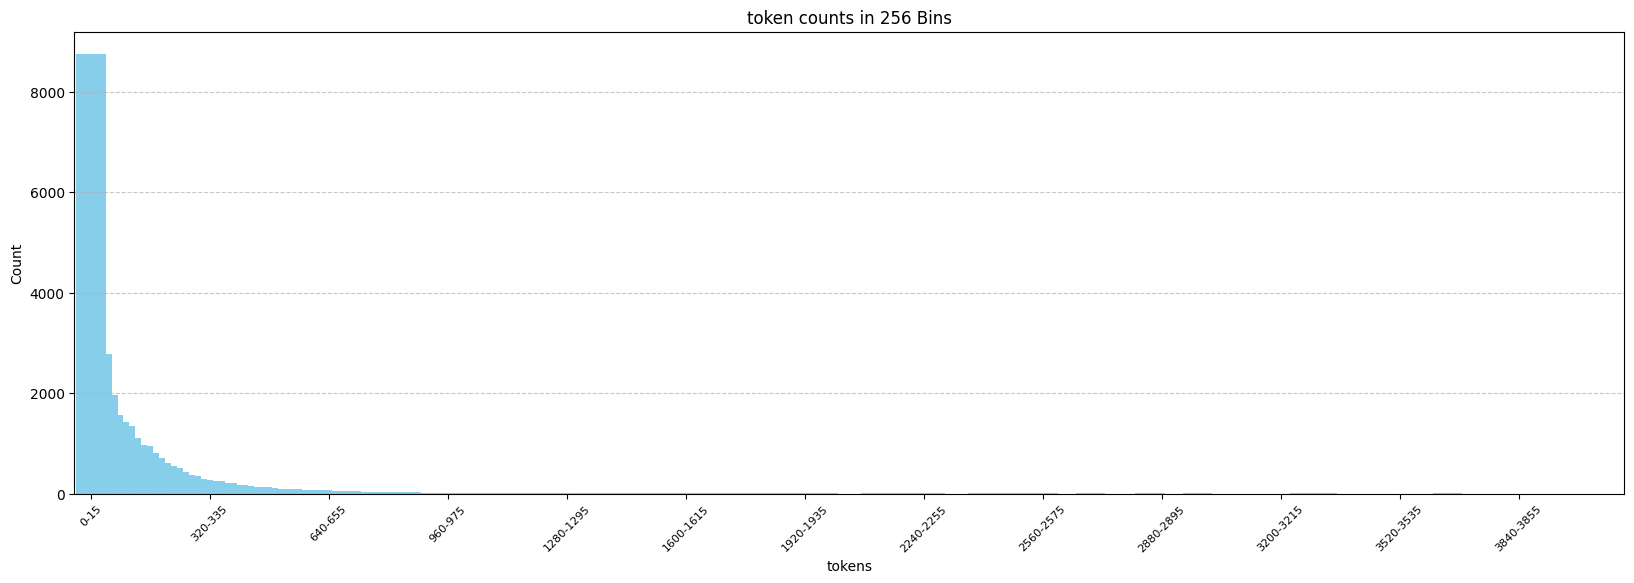

In [66]:
plot_token_length(df_len_b)

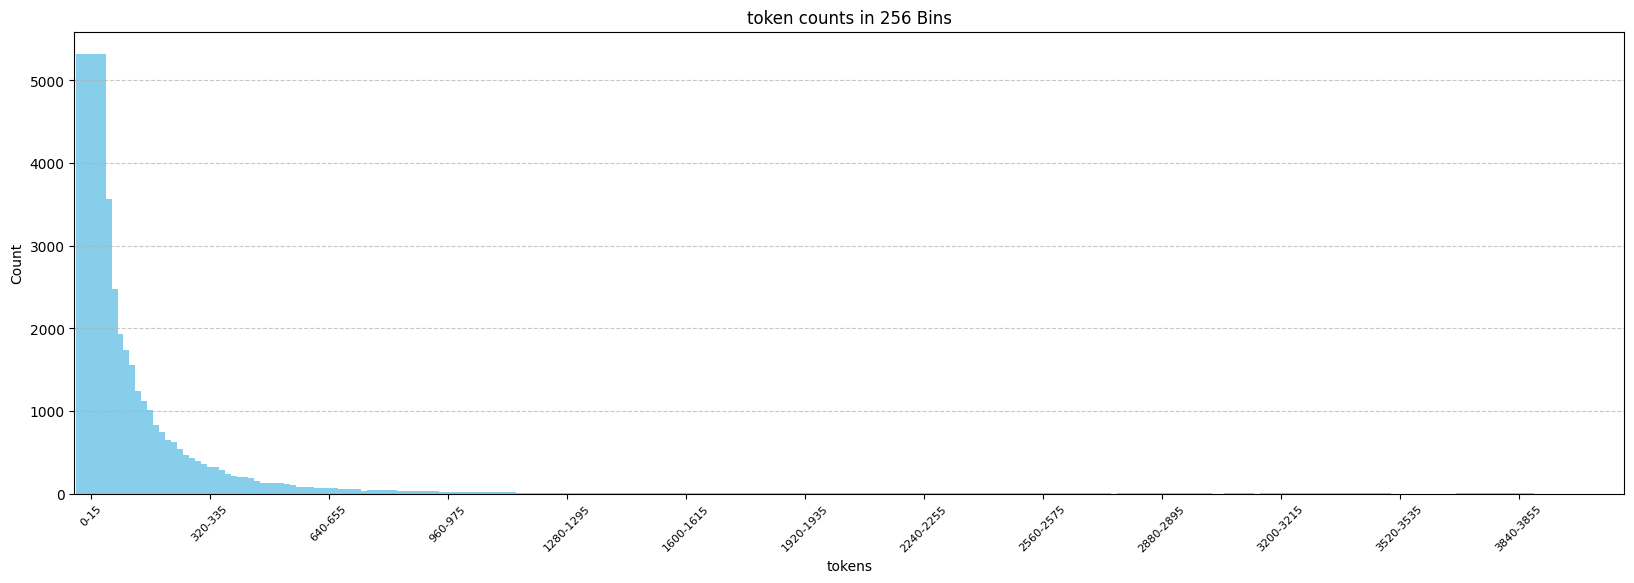

In [67]:
plot_token_length(df_len_a)

In [70]:
filtered_df = data_df[~data_df['id'].isin(df_len_abnormal_b['id'])]

In [72]:
filtered_df = filtered_df.reset_index(drop = True)
filtered_df['id'] = filtered_df.index

In [73]:
filtered_df.to_parquet(f'{data_prefix}/data_method_30k_filtered.parquet', engine = 'pyarrow')